# Civil Engineering Machine Learning Project
## Damage evaluation of reinforced concrete beams with varying thickness using the acoustic emission technique


***
## 1. Data Extraction

In [216]:
"""
Created on Tue Jul 18 03:12:39 2017

@author: Aamir
"""

'\nCreated on Tue Jul 18 03:12:39 2017\n\n@author: Aamir\n'

### Import Libraries

In [217]:

import os
import scipy.io
import numpy as np
import pandas as pd

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from IPython.display import SVG
import matplotlib.pyplot as plt

In [218]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

### Import and select relevant data 

In [219]:
data = pd.read_excel("concrete-damage-data.xlsx")
data = data.iloc[:,[4, 5, 6, 7, 8, 9, 10, 17, 18, 19]]
data = data.dropna()
data.reset_index(drop=True,inplace=True)

### Check data frame structure 

In [220]:
data.shape

(82873, 10)

In [221]:
data.dtypes

CH              object
RISE            object
COUN            object
ENER            object
DURATION        object
AMP             object
A_FRQ           object
SIG_STRNGTH     object
ABS_ENERGY      object
DAMAGE         float64
dtype: object

In [222]:
data.head()

,CH,RISE,COUN,ENER,DURATION,AMP,A_FRQ,SIG_STRNGTH,ABS_ENERGY,DAMAGE
0,4,9,5,2,114,52,44,14372,260.846,0.0
1,3,1,1,0,1,45,1000,115.9,2.124,0.0
2,3,23,3,1,69,48,43,7241,107.876,0.0
3,4,1,2,1,79,46,25,7024,85.976,0.0
4,3,22,3,1,86,48,35,9022,133.646,0.0


***
## 2. Data Cleaning
### Check and fill missing values 

In [223]:
data.count()

CH             82873
RISE           82873
COUN           82873
ENER           82873
DURATION       82873
AMP            82873
A_FRQ          82873
SIG_STRNGTH    82873
ABS_ENERGY     82873
DAMAGE         82873
dtype: int64

No missing data. Incomplete entries have already been removed.

### Convert to numeric columns 

In [224]:
data['CH'] = data['CH'].astype(int)
data['RISE'] = data['RISE'].astype(int)
data['COUN'] = data['COUN'].astype(int)
data['ENER'] = data['ENER'].astype(int)
data['DURATION'] = data['DURATION'].astype(int)
data['AMP'] = data['AMP'].astype(int)
data['A_FRQ'] = data['A_FRQ'].astype(int)
data['SIG_STRNGTH'] = data['SIG_STRNGTH'].astype(float)
data['ABS_ENERGY'] = data['ABS_ENERGY'].astype(float)
data['DAMAGE'] = data['DAMAGE'].astype(int)

data.dtypes

CH               int32
RISE             int32
COUN             int32
ENER             int32
DURATION         int32
AMP              int32
A_FRQ            int32
SIG_STRNGTH    float64
ABS_ENERGY     float64
DAMAGE           int32
dtype: object

In [225]:
data.to_excel("Aamirdata.xlsx")

In [226]:
data.head()

,CH,RISE,COUN,ENER,DURATION,AMP,A_FRQ,SIG_STRNGTH,ABS_ENERGY,DAMAGE
0,4,9,5,2,114,52,44,14372.0,260.846,0
1,3,1,1,0,1,45,1000,115.9,2.124,0
2,3,23,3,1,69,48,43,7241.0,107.876,0
3,4,1,2,1,79,46,25,7024.0,85.976,0
4,3,22,3,1,86,48,35,9022.0,133.646,0


### Normalize Data

In [227]:
mn = pd.DataFrame.mean(data)
vr = pd.DataFrame.var(data)

In [228]:
data.RISE = (data.RISE - mn.RISE) / vr.RISE
data.COUN = (data.COUN - mn.COUN) / vr.COUN
data.ENER = (data.ENER - mn.ENER) / vr.ENER
data.DURATION = (data.DURATION - mn.DURATION) / vr.DURATION
data.AMP = (data.AMP - mn.AMP) / vr.AMP
data.A_FRQ = (data.A_FRQ - mn.A_FRQ) / vr.A_FRQ
data.SIG_STRNGTH = (data.SIG_STRNGTH - mn.SIG_STRNGTH) / vr.SIG_STRNGTH
data.ABS_ENERGY = (data.ABS_ENERGY - mn.ABS_ENERGY) / vr.ABS_ENERGY

In [229]:
data.tail()

,CH,RISE,COUN,ENER,DURATION,AMP,A_FRQ,SIG_STRNGTH,ABS_ENERGY,DAMAGE
82868,3,-0.000109,-0.000480,-0.000426,-0.000020,-0.143455,0.014636,-6.818177e-08,-8.379418e-08,3
82869,4,-0.000101,-0.000313,-0.000369,-0.000018,0.028976,-0.000870,-5.872238e-08,-8.145447e-08,3
82870,4,-0.000109,-0.000480,-0.000426,-0.000020,-0.143455,0.014636,-6.885183e-08,-8.384629e-08,3
82871,3,-0.000109,-0.000480,-0.000426,-0.000020,-0.143455,0.014636,-6.885034e-08,-8.384592e-08,3
82872,3,-0.000109,-0.000468,-0.000417,-0.000019,-0.091726,-0.001343,-6.687031e-08,-8.360515e-08,3


In [230]:
X = np.array(data.iloc[:,0:9])
y = np.eye(4)[data['DAMAGE'].astype(int)]
n_cols = X.shape[1]

In [231]:
n_cols

9

Split Train/Test Sets

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [233]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((66298, 9), (16575, 9), (66298, 4), (16575, 4))

***
## 3. Train and Evaluate the Model
### Set target, features to train model 

### Specify the model

In [234]:
# Specify the model
model = Sequential()
model.add(Dense(5, activation='relu', input_shape = (n_cols,)))
# model.add(Dense(5, activation='relu'))
# model.add(Dense(5, activation='relu'))
# model.add(Dense(5, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(4, activation='softmax'))

early_stopping_monitor = EarlyStopping(patience=2)

# Compile the model
sgd = SGD(lr=0.1)#, decay=1e-6, momentum=1.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, validation_split=0.3, batch_size=64, epochs=100, callbacks=[early_stopping_monitor])


Train on 46408 samples, validate on 19890 samples
Epoch 1/100
46408/46408 [==============================] - 5s - loss: 0.8837 - acc: 0.4953 - val_loss: 0.8768 - val_acc: 0.5081
Epoch 2/100
46408/46408 [==============================] - 4s - loss: 0.8648 - acc: 0.5034 - val_loss: 0.8947 - val_acc: 0.4378
Epoch 3/100
46408/46408 [==============================] - 4s - loss: 0.8629 - acc: 0.5056 - val_loss: 0.8698 - val_acc: 0.5081
Epoch 4/100
46408/46408 [==============================] - 4s - loss: 0.8620 - acc: 0.5077 - val_loss: 0.8706 - val_acc: 0.5043
Epoch 5/100
46408/46408 [==============================] - 4s - loss: 0.8605 - acc: 0.5122 - val_loss: 0.8861 - val_acc: 0.4430
Epoch 6/100
46408/46408 [==============================] - 4s - loss: 0.8598 - acc: 0.5143 - val_loss: 0.8610 - val_acc: 0.5081
Epoch 7/100
46408/46408 [==============================] - 4s - loss: 0.8583 - acc: 0.5141 - val_loss: 0.9235 - val_acc: 0.4387
Epoch 8/100
46408/46408 [=============================

### Train/Validation Set Evaluation 

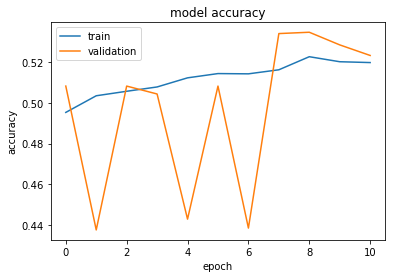

In [235]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

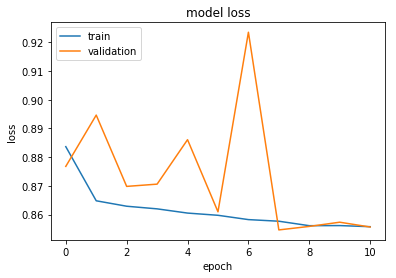

In [236]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Test Set Evaluation

In [238]:
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=1)

16512/16575 [============================>.] - ETA: 0s

In [243]:
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

acc: 52.01%
loss: 85.12%


***
## 5. Predict the Test set

### Select test model features 

### Make predictions 

***
## 6. Save Results
### Create the Solution 

In [ ]:
my_solution.index.name

### Save to CSV file 

In [ ]:
my_solution.to_csv("my_solution_six.csv")

***
***
# Rough Work 

In [ ]:
%matplotlib inline